# Atomic Charge Prediction

## Introduction

In this notebook we will machine-learn the relationship between an atomic descriptor and its electron density using neural networks.

The atomic descriptor is a numerical representation of the chemical environment of the atom. Several choices are available for testing.
Reference Mulliken charges were calculated for 134k molecules at the CCSD level: each took 1-4 hours. 


The problem is not trivial, even for humans.
<table><tr>
    <td>
        <img src="./images/complex-CX.png" width="350pt">
    </td><td>
        <img src="./images/complex-CH3-X.png" width="350pt">
    </td></tr>
</table>

On the left we see the distribution of s electron density on C atoms in the database. Different chemical environments are shown with different colours. The stacked histograms on the right show the details of charge density for CH$_3$-CX depending on the environment of CX. The total amount of possible environments for C up to the second order exceeds 100, and the figure suggests the presence of third order effects. This is too complex to treat accurately with human intuition. 

Let's see if we can train neural networks to give accurate predictions in milliseconds!

## Setup

Here we use the ANN to model the relationship between the descriptors of atoms in molecules and the partial atomic charge density.

In [2]:
# --- INITIAL DEFINITIONS ---
from sklearn.neural_network import MLPRegressor
import numpy, math, random
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase import Atoms
from visualise import view

Let's pick a descriptor and an atomic type.

Available descriptors are:
* boba: bag of bonds (per atom)
* boba2: bag of bonds - advanced (per atom)
* acsf: atom centered symmetry functions - 40k atoms max for each type
* gnn: graph based fingerprint from NanoLayers
* soap: smooth overlap of atomic positions (per atom)
* mbtr: manybody tensor representation (per atom)

Possible atom types are:
* 1 = Hydrogen
* 6 = Carbon
* 7 = Nitrogen
* 8 = Oxygen
* 9 = Fluorine


In [17]:
# Z is the atom type: allowed values are 1, 6, 7, 8, or 9
Z = 6

# TYPE is the descriptor type
TYPE = "boba"

#show descriptor details
print("\nDescriptor details")
desc = open("./data/descriptor."+TYPE+".txt","r").readlines()
for l in desc: print(l.strip())
print(" ")


Descriptor details
Bag of Bonds (atomic)

Each atom is described by 6 integer numbers:
1. coordination = total number of bonded neighbours
2. coordination = number of bonded H
3. coordination = number of bonded C
4. coordination = number of bonded N
5. coordination = number of bonded O
6. coordination = number of bonded F
 


Load the databases with the descriptors (input) and the correct charge densities (output). Databases are quite big, so we can decide how many samples to use for training.

In [18]:
# load input/output data
trainIn = load_npz("./data/charge."+str(Z)+".input."+TYPE+".npz").toarray()
trainOut = numpy.load("./data/charge."+str(Z)+".output.npy")
trainOut = trainOut[0:trainIn.shape[0]]

# decide how many samples to take from the database
samples  = min(trainIn.shape[0], 1000) # change the number here if needed!

print("training samples:   "+str(samples))
print("validation samples: "+str(trainIn.shape[0]-samples))
print("number of features: {}".format(trainIn.shape[1]))

# 70-30 split between training and validation
validIn = trainIn[samples:samples+1000]
validOut = trainOut[samples:samples+1000]

trainIn  = trainIn[0:samples]
trainOut = trainOut[0:samples]

# shift and scale the inputs - OPTIONAL
train_mean = numpy.mean(trainIn, axis=0)
train_std = numpy.std(trainIn, axis=0)
train_std[train_std == 0] = 1
for a in range(trainIn.shape[1]):
    trainIn[:,a] -= train_mean[a]
    trainIn[:,a] /= train_std[a]

# also for validation set
for a in range(validIn.shape[1]):
    validIn[:,a] -= train_mean[a]
    validIn[:,a] /= train_std[a]


# show the first few descriptors
print("\nDescriptors for the first 5 atoms:")
print(trainIn[0:5])

training samples:   1000
validation samples: 845557
number of features: 6

Descriptors for the first 5 atoms:
[[ 0.59400577  1.73118752 -0.85088621 -0.55082886 -0.63004845 -0.0316386 ]
 [ 0.59400577  0.71582827  0.28211807 -0.55082886 -0.63004845 -0.0316386 ]
 [-1.10801649 -1.31489023  0.28211807 -0.55082886  1.30261551 -0.0316386 ]
 [-1.10801649 -1.31489023  0.28211807 -0.55082886  1.30261551 -0.0316386 ]
 [-1.10801649 -0.29953098  0.28211807 -0.55082886 -0.63004845 -0.0316386 ]]


Next we setup a multilayer perceptron of suitable size. Out package of choice is scikit-learn, but more efficient ones are available.<br>
Check the scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html">documentation</a> for a list of parameters.

In [15]:
# setup the neural network
# alpha is a regularisation parameter, explained later

nn = MLPRegressor(hidden_layer_sizes=(10),  activation='tanh', solver='adam', alpha=0.01, learning_rate='adaptive')

## Training
Now comes the tough part! The idea of training is to evaluate the ANN with the training inputs and measure its error (since we know the correct outputs). It is then possible to compute the derivative (gradient) of the error w.r.t. each parameter (connections and biases). By shifting the parameters in the opposite direction of the gradient, we obtain a better set of parameters, that should give smaller error.
This procedure can be repeated until the error is minimised.<br><br>
It may take a while...

In [16]:
# use this to change some parameters during training if needed
nn.set_params(solver='lbfgs')

nn.fit(trainIn, trainOut);

Check the ANN quality with a regression plot, showing the mismatch between the exact and NN predicted outputs for the validation set.

Mean Abs Error (training)  :  0.053976877237356786
Mean Abs Error (validation):  0.057702090505704885


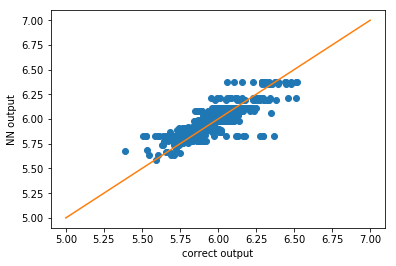

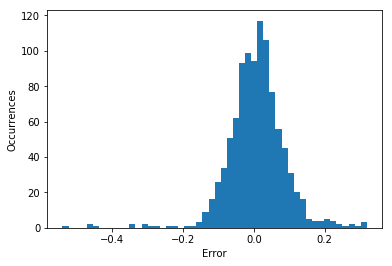

In [7]:
# evaluate the training and validation error
trainMLOut = nn.predict(trainIn)
validMLOut = nn.predict(validIn)

print ("Mean Abs Error (training)  : ", (numpy.abs(trainMLOut-trainOut)).mean())
print ("Mean Abs Error (validation): ", (numpy.abs(validMLOut-validOut)).mean())

plt.plot(validOut,validMLOut,'o')
plt.plot([Z-1,Z+1],[Z-1,Z+1]) # perfect fit line
plt.xlabel('correct output')
plt.ylabel('NN output')
plt.show()

# error histogram
plt.hist(validMLOut-validOut,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

# Exercises

### 1. Compare descriptors
Test the accuracy of different descriptors with the same NN size.

In [8]:
# DIY code here...


### 2. Optimal NN
Find the smallest NN that gives good accuracy.

In [9]:
# DIY code here...


### 3. Training sample size issues
Check whether the descriptor fails because it does not contain enough information, or because there was not enough training data.

In [10]:
# DIY code here...

### 4. Combine with Principal Component Analysis - Advanced

Reduce the descriptor size with PCA (check the PCA.ipynb notebook) and train again. Can you get similar accuracy with much smaller networks?

In [11]:
# DIY code here...

### 5. Putting it all together
After training NNs for each atomic species (MBTR), combine them into one program that predicts charges for all atoms in a molecule.

* Compute local MBTR for the molecule below.
* Compute all atomic charges with the NNs.
* Is the total charge zero? If not, normalise it.

**Note: Careful about the training: if the training data was transformed, the MBTR here should be as well.**

In [12]:
# atomic positions as matrix
molxyz = numpy.load("./data/molecule.coords.npy")
# atom types
moltyp = numpy.load("./data/molecule.types.npy")

atoms_sys = Atoms(positions=molxyz, numbers=moltyp)
view(atoms_sys)

In [ ]:
# compute MBTR descriptor for the molecule
# ...


In [ ]:
# compute all atomic charghes using previously trained NNs
# ...


### 5. Analyse the chemical environments

Try to plot the ACSF/SOAP chemical environemnts of C using t-SNE. Can you identify clusters of similar C atoms? What about their partial charge?